<center><h1>Making Merger Tree from m3p output</h1></center>

In [1]:
import numpy as np
import m3p_merger
import matplotlib.pyplot as plt
import importlib
import matplotlib
importlib.reload(m3p_merger)

<module 'm3p_merger' from 'C:\\Users\\David\\Google Drive\\Axion PhD\\PeakPatch\\m3p_merger\\m3p_merger.py'>

In [3]:
Omega_m0 = 0.3
Omega_r0 = 8.486e-5
h = 0.7

G = 6.674e-11 # m^3 kg^(-1) s^(-2)
Mpc = 3.086e22 # m 
Msol = 1.988e30 # kg
Mpcpkm = (1e3/3.0869e22)
H = 100*Mpcpkm*h # /s
Omega_DM = 0.267

rho_c = 3/(8*np.pi*G)*Mpc**3/Msol*H**2 # Msol / Mpc^(-3)
rho_bg = 0.267*rho_c

z_eq = Omega_m0/Omega_r0 - 1
a_eq = 1/(1+z_eq)


In [7]:
#ppFile = pathPrefix+"../inputs/"+"inputs.ax_manyz"
ppFile = "inputs.axbig_manyz3"
peak_list, boxsize = m3p_merger.MakePeakList(ppFile,startIndex = 0, printOutput = True)

	Loading file (109 of 109): axOut/big3/axion_big3final_halos_108.hdf5


In [30]:
peak_list.shape

(7,)

<h2><center>Find which trees are interesting</center></h2>

In [8]:
out = m3p_merger.BuildMergerTree(peak_list, ppFile, redshift_indicies='all')

for i in range(len(out)):
    if len(out[i][25]) >= 2:
        print(i, end = '* ')

12* 22* 30* 40* 41* 47* 54* 62* 76* 85* 101* 102* 115* 120* 127* 131* 132* 166* 181* 198* 200* 218* 295* 306* 324* 335* 336* 355* 357* 359* 368* 371* 376* 405* 407* 432* 448* 490* 501* 514* 547* 592* 593* 600* 606* 610* 637* 683* 685* 769* 849* 852* 902* 912* 925* 958* 960* 985* 1023* 1056* 1058* 1118* 1128* 1158* 1160* 1175* 1265* 1272* 1276* 1287* 1302* 1357* 1386* 1393* 1498* 1513* 1541* 1579* 1583* 1596* 1634* 1647* 1651* 1672* 1675* 1684* 1716* 1721* 1761* 1771* 1776* 1786* 1800* 1830* 1839* 1840* 1845* 1853* 1859* 1864* 1867* 1871* 1896* 1898* 1917* 1920* 1953* 1956* 1957* 1984* 1986* 1989* 1994* 2007* 2008* 2013* 2022* 2038* 2065* 2075* 2080* 2150* 2161* 2173* 2177* 2247* 2278* 2301* 2316* 2326* 2329* 2349* 2359* 2365* 2379* 2382* 2386* 2411* 2417* 2426* 2432* 2436* 2438* 2446* 2447* 2455* 2465* 2480* 2504* 2532* 2536* 2549* 2550* 2551* 2570* 2573* 2604* 2636* 2647* 2652* 2662* 2676* 2699* 2713* 2726* 2734* 2763* 2776* 2788* 2793* 2808* 2813* 2821* 2822* 2823* 2831* 2839* 2842* 

<h2><center>Calculate Merger Tree</center></h2>

In [11]:
importlib.reload(m3p_merger)
#indicies = np.arange(1000)
out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 12)
#np.save("./FinalGraphs/Data/MergerTreeExample.npy",out[0])

In [10]:
importlib.reload(m3p_merger)
out2 = m3p_merger.BuildMergerTree2(peak_list, ppFile, final_halos_indicies = 12)

<h2><center>Plot all peaks on each other</center></h2>

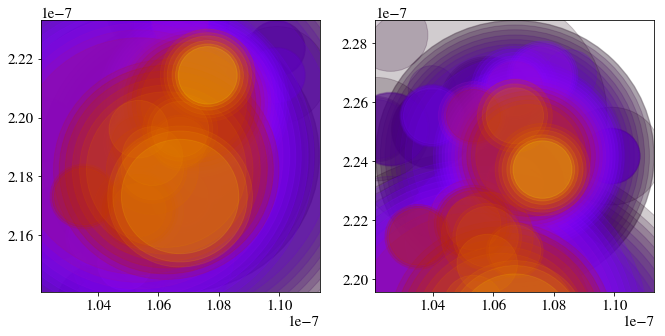

In [68]:
importlib.reload(m3p_merger)
#out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 797, printOutput = True)
m3p_merger.plotMergerPatches(out2[0], ppFile)

<h2><center>Plot merger tree</center></h2>

C:\Users\David\Google Drive\Axion PhD\PeakPatch\m3p_merger\m3p_merger.py:521: RuntimeWarning: invalid value encountered in log10
  colorVal = scalarMap.to_rgba(np.log10(merger_list[i][j,4]))
C:\Users\David\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


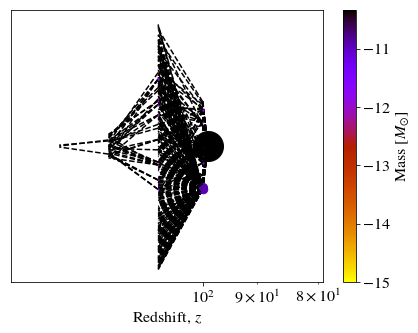

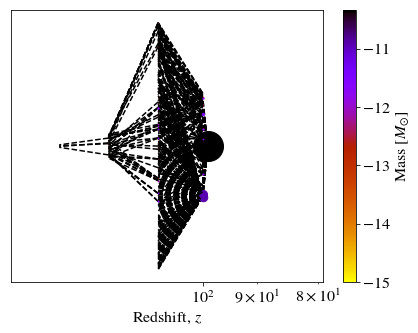

In [31]:
importlib.reload(m3p_merger)
ppFile = "inputs.axbig_manyz3"

out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 18603)
fig = m3p_merger.plotMergerTree(out[0][::20], ppFile, startIndex=0, font_size = 16, log = True,
                          colorbar=True, colorbar_title = "Mass [$M_{\odot}$]")
plt.show()

out2 = m3p_merger.BuildMergerTree2(peak_list, ppFile, final_halos_indicies = 18603)
fig = m3p_merger.plotMergerTree(out2[0][::20], ppFile, startIndex=0, font_size = 16, log = True,
                          colorbar=True, colorbar_title = "Mass [$M_{\odot}$]")

<h3>Checking Linear Interpolation</h3>

(10000.0, 90)

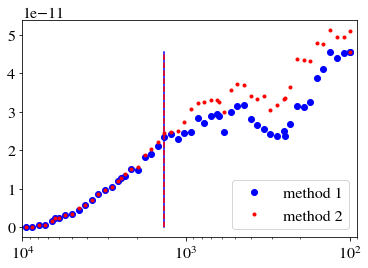

In [29]:
importlib.reload(m3p_merger)

halo_index = 18603
f = 0.01

out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = halo_index)
#zColLin, ProgMassLin, zLin = m3p_merger.FindCollapseRedshift(out[0], f, ppFile,startIndex = 25, interp = "Linear")
zCol, ProgMass, z = m3p_merger.FindCollapseRedshift(out[0], f, ppFile,startIndex = 0, interp = "None")
plt.semilogx(z, ProgMass, 'bo', ms=6, label = "method 1")

#plt.semilogx([zColLin, zColLin], [0,ProgMassLin[0]],'k-')
plt.semilogx([zCol, zCol], [0,ProgMass[0]],'b-')

plt.xlim(1e4, z[0])

out = m3p_merger.BuildMergerTree2(peak_list, ppFile, final_halos_indicies = halo_index)
zCol, ProgMass, z = m3p_merger.FindCollapseRedshift(out[0], f, ppFile,startIndex = 0, interp = "None")
plt.semilogx(z, ProgMass, 'r.', ms=6, label ="method 2")

plt.semilogx([zCol, zCol], [0,ProgMass[0]],'r--')

plt.legend(loc=4)
plt.xlim(1e4, 90)


#np.save("./FinalGraphs/Data/MassGrowth.npy", [z, ProgMass, zCol])

In [19]:
importlib.reload(m3p_merger)
ppFile = "inputs.axbig_manyz3"

frac = 0
startIndicies = [0, 25, 50, 74]

for i, startIndex in enumerate(startIndicies):  
    z0 = np.logspace(2,6,100)[startIndex]
    
    print("-"*40)
    print("Calculating collapse redshifts\n   ppFile: {}\n   z0={:.3}\n".format(ppFile, z0))
    
    print("Building peak list...")
    peak_list, boxsize = m3p_merger.MakePeakList(ppFile, startIndex = startIndex, printOutput = True)
    print("Done.\n")

    print("Building merger trees...")
    out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = "all", printOutput = True)
    print("Done.\n")

    print("Calculating collapse redshifts...")
    collapse_redshifts = np.zeros(len(out))
    for i in range(len(out)):
        collapse_redshifts[i] = m3p_merger.FindCollapseRedshift(out[i], frac, ppFile, interp = "None")[0]
    print("Done.\n")

    print("Fetching final halo masses...")
    masses = np.zeros(len(out))
    for i in range(len(out)):
        masses[i] = out[i][0][0,4]
    print("Done.\n")

    print("Fetching final halo radii...")
    radii = np.zeros(len(out))
    for i in range(len(out)):
        radii[i] = out[i][0][0,3]
    print("Done.\n")

    print("Saving data...")
    np.save("ConcEvolution/axbig_manyz_CollapseRedshifts_f0_z0_{}".format(z0), collapse_redshifts)
    np.save("ConcEvolution/axbig_manyz_FinalMasses_f0_z0_{}".format(z0), masses)
    np.save("ConcEvolution/axbig_manyz_FinalRadii_f0_z0_{}".format(z0), radii)
    print("Done.\n")

----------------------------------------
Calculating collapse redshifts
   ppFile: inputs.axbig_manyz
   z0=1e+02

Building peak list...
	Loading file (100 of 100): axOut/axionfinal_halos_99.hdf5
Done.

Building merger trees...
	Final redshift index 99 out of 100
	i.e. Earlist halo at z = 1000000.0
	Halo 3110 of 3111: 99 complete of 99
Done.

Calculating collapse redshifts...
Done.

Fetching final halo masses...
Done.

Fetching final halo radii...
Done.

Saving data...
Done.

----------------------------------------
Calculating collapse redshifts
   ppFile: inputs.axbig_manyz
   z0=1.02e+03

Building peak list...
	Loading file (75 of 75): axOut/axionfinal_halos_99.hdf5
Done.

Building merger trees...
	Final redshift index 74 out of 75
	i.e. Earlist halo at z = 97700.0
	Halo 125458 of 125459: 74 complete of 74
Done.

Calculating collapse redshifts...
Done.

Fetching final halo masses...
Done.

Fetching final halo radii...
Done.

Saving data...
Done.

------------------------------------